# Text Mining pada Twitter untuk Sentiment Analysis terkait Suatu Topik


Pada _notebook_ ini, suatu proses _text mining_ akan diterapkan pada Twitter untuk mendapatkan berbagai _post_ atau _tweet_ terkait suatu topik.
Twitter atau X dipilih karena merupakan media sosial yang fokus pada teks dan teks-nya pun bersifat pendek.
Topik yang diambil adalah wasit AFC Cup yang sempat menciptakan trend kata "wasit" di Twitter sejak pertandingan terakhir Indonesia pada 29 April sampai 1 Mei.

Proses _text mining_ diterapkan dengan _library_ [selenium](https://pypi.org/project/selenium/) untuk automatisasi proses di _browser_ dan [BeautifulSoup](https://pypi.org/project/beautifulsoup4/) untuk ekstraksi teks dari HTML.
Berbagai _tweet_ yang didapatkan kemudian masuk ke proses _sentiment analysis_.
Itu dilakukan dengan suatu model berbasis BERT yang didapatkan dari [Hugging Face](https://huggingface.co/)


## Twitter Mining


### Initialization


Terdapat berbagai _module_ yang digunakan:

-   `os` untuk menulis ke _file_
-   `time` untuk fungsi `sleep()`
-   `typing` untuk membuat _custom type_
-   `tqdm` untuk _progress bar_
-   `BeautifulSoup` atau `bs4` untuk automatisasi proses di _browser_
-   `selenium` untuk ekstraksi teks dari HTML

Selain itu, terdapat _custom type_ untuk memudahkan _development_ atau _coding_, yaitu `TweetStats` dan `Tweet`


In [ ]:
import os

import time

from typing import TypedDict

from tqdm import tqdm

from bs4 import BeautifulSoup
from bs4.element import Tag

from selenium import webdriver
from selenium.webdriver import EdgeOptions
from selenium.webdriver.remote.webdriver import WebDriver

In [ ]:
class TweetStats(TypedDict):
    replies: int
    reposts: int
    likes: int
    views: int


class Tweet(TweetStats):
    href: str
    user: str
    timestamp: str
    text: str


TweetList = list[Tweet]

### Login Twitter


Proses login ke Twitter dilakukan seperti login biasa dengan _username_ dan _password_.
Untuk alasan keamanan, _password_ nya disimpan dalam file bernama "password", tidak ditulis langsung di sini.
Meski alurnya biasa, namun prosesnya di-automatisasi sehingga tidak perlu _manual effort_.
Automatisasi dilakukan melalui `selenium` dengan menunggu _input element_ muncul kemudian mengisinya.


In [ ]:
def login_twitter(driver: WebDriver, username: str, password: str):
    from selenium.webdriver import Keys
    from selenium.webdriver.common.by import By
    from selenium.webdriver.support import expected_conditions as EC
    from selenium.webdriver.support.wait import WebDriverWait

    login_url = "https://twitter.com/i/flow/login"

    # Load the login page
    driver.get(login_url)

    # Wait for the username form to load, then fill it in
    username_element = WebDriverWait(driver, 20).until(
        EC.visibility_of_element_located(
            (By.CSS_SELECTOR, 'input[autocomplete="username"]')
        )
    )
    username_element.send_keys(username)
    username_element.send_keys(Keys.ENTER)

    # Wait for the password form to load, then fill it in
    password_element = WebDriverWait(driver, 10).until(
        EC.visibility_of_element_located((By.CSS_SELECTOR, 'input[name="password"]'))
    )
    password_element.send_keys(password)
    password_element.send_keys(Keys.ENTER)

### Read Tweets


Proses pembacaan _tweets_ dilakukan dengan mengolah _page source_ dengan `BeautifulSoup`.
Setiap elemen _tweet_ bisa diidentifikasi dengan _attribute_ "data-testid=tweet".

Dari suatu elemen _tweet_, berbagai informasi bisa di-ekstrak dengan identifikasi tertentu,
misal nama pengguna dengan _attribute_ "data-testid=User-Name" atau teks _tweet_ dengan _attribute_ "data-testid=tweetText".
Selain itu, terdapat beberapa informasi lain yang di-ekstrak dari suatu _tweet_:
href, timestamp, replies, reposts, likes, views.

Berbagai informasi itu kemudian dikumpulkan dan disimpan dalam suatu `list` dengan tipe data `TweetList`


In [ ]:
def parse_tweet_stats(stats: str) -> TweetStats:
    # example of stats: "1 reply, 2 reposts, 1 like, 127 views"
    # another example: "3 replies, 10 likes, 200 view"
    # yet another example: "1 like, 1 view"
    if " " not in stats:
        dc = {}
    else:
        dc = {
            name[:4]: int(num)
            for num, name in [stat.split(" ") for stat in stats.split(", ")]
        }
    return {
        "replies": dc.get("repl", 0),
        "reposts": dc.get("repo", 0),
        "likes": dc.get("like", 0),
        "views": dc.get("view", 0),
    }


In [ ]:
def read_tweets(source: str) -> TweetList:
    # parse the html source and get list of tweet elements
    soup = BeautifulSoup(source, "html.parser")
    tweet_elements: list[Tag] = soup.find_all("article", {"data-testid": "tweet"})

    tweets: TweetList = []
    for tweet_element in tweet_elements:
        # get username element and name of user
        username_element = tweet_element.find("div", {"data-testid": "User-Name"})
        if not isinstance(username_element, Tag):
            continue
        username_children = username_element.contents
        user = username_children[0].text

        # get time element and timestamp from the last child of the username element
        time_element = isinstance(username_children[-1], Tag) and (
            username_children[-1].find("time")
        )
        if not isinstance(time_element, Tag):
            continue
        timestamp = time_element.attrs.get("datetime", "")

        # get href from the parent of the time element
        href_element = time_element.parent
        if not isinstance(href_element, Tag):
            continue
        href = href_element.attrs["href"]

        # get text element and text of the tweet
        text_element = tweet_element.find("div", {"data-testid": "tweetText"})
        if not isinstance(text_element, Tag):
            continue
        text = text_element.text

        # get stats element from the parent of the reply element, then parse the stats text
        reply_element = tweet_element.find("div", {"data-testid": "reply"})
        stats = (
            isinstance(reply_element, Tag)
            and isinstance(reply_element.parent, Tag)
            and isinstance(reply_element.parent.parent, Tag)
            and reply_element.parent.parent.attrs.get("aria-label", "")
        )
        stat_values = parse_tweet_stats(stats or "")

        tweets.append(
            {
                "href": href,
                "user": user,
                "timestamp": timestamp,
                "text": text,
                **stat_values,
            }
        )
    return tweets


### Save Tweets


Simpan `dictionary` dengan tipe `Tweet` ke suatu file TSV.
TSV lebih sesuai dibanding CSV karena teks dari _tweet_ itu sering mengandung koma (,).
Ketika file baru dibuat, terdapat `header` yang ditulis di baris pertama.
Ketika ada suatu `Tweet`, maka satu baris baru ditulis.


In [ ]:
def write_tweet_to_tsv(filename: str, tweet: Tweet):
    # write header if file is just created
    if not os.path.isfile(filename):
        with open(filename, "w") as f:
            f.write(
                "href, user, timestamp, text, replies, reposts, likes, views\n".replace(
                    ", ", "\t"
                )
            )

    # clean text by replacing newlines and tabs with their escape sequences
    clean_text = tweet["text"].replace("\n", "\\n").replace("\t", "\\t")

    # write a tweet to a single line in the tsv file
    with open(filename, "a", encoding="utf-8") as f:
        f.write(
            "\t".join(
                [
                    tweet["href"],
                    tweet["user"],
                    tweet["timestamp"],
                    clean_text,
                    str(tweet["replies"]),
                    str(tweet["reposts"]),
                    str(tweet["likes"]),
                    str(tweet["views"]),
                ]
            )
            + "\n"
        )


### Run Mining


_Mining_ dilakukan dengan terlebih dahulu mendefinisikan _username_ dan _password_ untuk _login_ serta mendefinisikan URL yang dijadikan target untuk _mining_.
Setelah itu, terdapat pendefinisian _options_ untuk _web driver_.
_Web driver_ yang digunakan di sini adalah Edge, tetapi seharusnya tidak berbeda jika menggunakan Chrome.

Setelah pendefinisian _web driver_, yang pertama dilakukan tentu adalah _login_.
Kemudian, _web driver_ membuka setiap url yang dijadikan target.
Untuk setiap url, terdapat berbagai hal untuk membaca laman dan mengekstrak _tweets_:
_scrolling_ otomatis, ekstraksi setiap _tweet_, penyimpanan hasil ekstraksi _tweet_, dan lainnya.
Perlu diperhatikan bahwa ketika _scrolling_, _page source_ tidak lagi mengandung _tweets_ sebelumnya.
Karenanya, pembacaan laman perlu dilakukan setiap kali _scroll_.
Penjelasan lebih lanjut terdapat pada _comment_ di kode.


In [ ]:
username = "pandegaabyan"
password = ""
with open("password", "r") as f:
    password = f.read().strip()

target_urls = [
    r"https://twitter.com/search?q=wasit%20afc%20until%3A2024-04-27%20since%3A2024-04-26&src=typed_query&f=top",
    r"https://twitter.com/search?q=wasit%20until%3A2024-04-27%20since%3A2024-04-26&src=typed_query&f=top",
    r"https://twitter.com/search?q=wasit%20afc%20until%3A2024-04-28%20since%3A2024-04-27&src=typed_query&f=top",
    r"https://twitter.com/search?q=wasit%20until%3A2024-04-28%20since%3A2024-04-27&src=typed_query&f=top",
    r"https://twitter.com/search?q=wasit%20afc%20until%3A2024-04-29%20since%3A2024-04-28&src=typed_query&f=top",
    r"https://twitter.com/search?q=wasit%20until%3A2024-04-29%20since%3A2024-04-28&src=typed_query&f=top",
    r"https://twitter.com/search?q=wasit%20afc%20until%3A2024-04-30%20since%3A2024-04-29&src=typed_query&f=top",
    r"https://twitter.com/search?q=wasit%20until%3A2024-04-30%20since%3A2024-04-29&src=typed_query&f=top",
    r"https://twitter.com/search?q=wasit%20afc%20until%3A2024-05-01%20since%3A2024-04-30&src=typed_query&f=top",
    r"https://twitter.com/search?q=wasit%20until%3A2024-05-01%20since%3A2024-04-30&src=typed_query&f=top",
    r"https://twitter.com/search?q=wasit%20afc%20until%3A2024-05-02%20since%3A2024-05-01&src=typed_query&f=top",
    r"https://twitter.com/search?q=wasit%20until%3A2024-05-02%20since%3A2024-05-01&src=typed_query&f=top",
]

In [ ]:
edge_options = EdgeOptions()

# override the default setting related to automation
edge_options.add_experimental_option("excludeSwitches", ["enable-automation"])

# disable image rendering
edge_options.add_experimental_option(
    "prefs", {"profile.managed_default_content_settings.images": 2}
)


In [19]:
edge_driver = webdriver.Edge(edge_options)

login_twitter(edge_driver, username, password)

# wait for the login to fully complete
time.sleep(10)

urls_and_tweet_counts: list[
    tuple[str, int]
] = []  # list of (url, tweet count of the url)
prev_tweet_ids: set[str] = set()  # set of tweet ids that have been collected
max_wait_seconds = 60  # maximum seconds to wait for the tweets to load when scrolling
max_scrolls = 1000  # maximum number of scrolls to do

for target_url in target_urls:
    print(target_url)
    edge_driver.get(target_url)

    # wait for the page to fully load
    time.sleep(10)

    # get the screen height (not the height of the page)
    screen_height = edge_driver.execute_script("return window.screen.height;")

    progress = tqdm(range(max_scrolls))  # progress bar
    for i in progress:
        # automatically scroll by one screen height
        edge_driver.execute_script(
            "window.scrollTo(0, {screen_height}*{i});".format(
                screen_height=screen_height, i=i
            )
        )

        # read tweets from current page source
        tweets = read_tweets(edge_driver.page_source)

        # write tweets to the tsv file and add the tweet ids to the set
        for tweet in tweets:
            tweet_id = tweet["href"].split("/")[-1]
            if tweet_id in prev_tweet_ids:
                continue
            prev_tweet_ids.add(tweet_id)
            write_tweet_to_tsv("tweets.tsv", tweet)

        # update the progress bar
        progress.set_postfix_str(f"{len(prev_tweet_ids)} tweets")

        # wait for the next tweets to load
        for j in range(max_wait_seconds):
            scroll_height = edge_driver.execute_script(
                "return document.body.scrollHeight;"
            )
            if (screen_height) * i < scroll_height:
                break
            time.sleep(1)
        if j == max_wait_seconds - 1:
            break

        time.sleep(1)

    # add the url and tweet count to the list
    if len(urls_and_tweet_counts) == 0:
        tweet_count = len(prev_tweet_ids)
    else:
        tweet_count = len(prev_tweet_ids) - urls_and_tweet_counts[-1][1]
    urls_and_tweet_counts.append((target_url, tweet_count))



https://twitter.com/search?q=wasit%20afc%20until%3A2024-04-27%20since%3A2024-04-26&src=typed_query&f=top
1%| | 11/1000 [01:18<1:58:12, 7.17s/it, 24 tweets]
https://twitter.com/search?q=wasit%20until%3A2024-04-27%20since%3A2024-04-26&src=typed_query&f=top
9%|▉ | 92/1000 [03:44<36:56, 2.44s/it, 292 tweets]
https://twitter.com/search?q=wasit%20afc%20until%3A2024-04-28%20since%3A2024-04-27&src=typed_query&f=top
0%| | 4/1000 [01:08<4:44:12, 17.12s/it, 303 tweets]
https://twitter.com/search?q=wasit%20until%3A2024-04-28%20since%3A2024-04-27&src=typed_query&f=top
5%|▍ | 48/1000 [02:29<49:22, 3.11s/it, 482 tweets]
https://twitter.com/search?q=wasit%20afc%20until%3A2024-04-29%20since%3A2024-04-28&src=typed_query&f=top
0%| | 4/1000 [01:08<4:43:52, 17.10s/it, 4 tweets]
https://twitter.com/search?q=wasit%20until%3A2024-04-29%20since%3A2024-04-28&src=typed_query&f=top
8%|▊ | 81/1000 [03:23<38:25, 2.51s/it, 253 tweets]
https://twitter.com/search?q=wasit%20afc%20until%3A2024-04-30%20since%3A2024-04-2

In [ ]:
# save the list of urls and tweet counts to a file
with open("urls_and_tweet_counts.txt", "w") as f:
    for url, count in urls_and_tweet_counts:
        f.write(f"{url} {count}\n")


## Sentiment Analysis


### Initialization


Terdapat berbagai _module_ yang digunakan:

-   `urllib` untuk _decode_ url
-   `tqdm` untuk _progress bar_
-   `numpy` untuk pengolahan _array_
-   `pandas` untuk pengolahan data tabular
-   `matplotlib` untuk visualisasi
-   `transformers` untuk menjalankan model dari Hugging Face


In [1]:
from urllib.parse import unquote

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transformers import pipeline

### Load and Transform Data


Data hasil _mining_ sebelumnya di-_load_ kemudian diolah:

-   File `tweets.tsv` di-_load_ dengan `pandas` menjadi `DataFrame` bernama `tweets_df`
-   File `urls_and_tweet_counts.txt` di-_load_ secara manual dan diolah menjadi variabel `urls_and_tweet_counts`
-   Dari `urls_and_tweet_counts`, dibuatlah `queries_and_tweet_counts` berisi _search query_ dan banyaknya _tweet_
-   Dari `queries_and_tweet_counts`, dibuatlah `query_list` berisi daftar _search query_ untuk digabungkan dengan `tweets_df`
-   Dari `tweets_df` dan `query_list`, dibuatlah `new_tweets_df` yang hanya terdiri dari tiga kolom: _search query_, _date_ dari _tweet_, dan teks dari _tweet_


In [3]:
tweets_df = pd.read_csv("tweets.tsv", sep="\t")

tweets_df

,href,user,timestamp,text,replies,reposts,likes,views
0,/MafiaWasit/status/1783675178800783580,Komisi Wasit,2024-04-26T01:51:16.000Z,Ini ekspresi Erick Thohir saat Rapat Pleno AFC...,105,384,4054,341537.0
1,/MafiaWasit/status/1783709277225701719,Komisi Wasit,2024-04-26T04:06:46.000Z,"ini baru Piala AFC Kategori UMUR, gimana kalau...",145,1663,8870,499580.0
2,/betisseksi/status/1783842179414401102,Sonny Ardi,2024-04-26T12:54:52.000Z,Kemungkinan besar Tim kita akan bertemu dengan...,0,0,0,66.0
3,/MztYowel/status/1783833984398688757,mzt yowel,2024-04-26T12:22:18.000Z,Jika @AFC Ingin terlihat bagus di MATA DUNIA\n...,0,0,0,43.0
4,/wartapesona/status/1783779346706211031,WartaPesona.com,2024-04-26T08:45:11.000Z,"Kena Karma, Jepang taklukkan Tuan tumah Qatar ...",0,0,0,37.0
...,...,...,...,...,...,...,...,...
1454,/CekFurkan126091/status/1785479747159707891,Cek Furkan,2024-05-01T01:21:58.000Z,Wsit Fack You,0,0,0,2.0
1455,/AntoSmartz/status/1785490329984205141,Co_Jkt,2024-05-01T02:04:02.000Z,Warning!!!,0,0,0,7.0
1456,/OposisiCerdas/status/1785499387399213454,OposisiCerdas.com,2024-05-01T02:40:01.000Z,Heboh! Aksi Pendukung Timnas Indonesia U-23 Pu...,0,14,21,514.0
1457,/Politika2024/status/1785475230246621664,Hysteria,2024-05-01T01:04:02.000Z,Yg salah wasit apa petugas VAR boss,0,0,0,1.0


In [7]:
with open("urls_and_tweet_counts.txt", "r") as f:
    lines = f.readlines()
    urls_and_tweet_counts: list[tuple[str, int]] = [
        (str(url), int(count))
        for url, count in [line.strip().split(" ") for line in lines]
    ]

urls_and_tweet_counts

[('https://twitter.com/search?q=wasit%20afc%20until%3A2024-04-27%20since%3A2024-04-26&src=typed_query&f=top',
  24),
 ('https://twitter.com/search?q=wasit%20until%3A2024-04-27%20since%3A2024-04-26&src=typed_query&f=top',
  268),
 ('https://twitter.com/search?q=wasit%20afc%20until%3A2024-04-28%20since%3A2024-04-27&src=typed_query&f=top',
  11),
 ('https://twitter.com/search?q=wasit%20until%3A2024-04-28%20since%3A2024-04-27&src=typed_query&f=top',
  179),
 ('https://twitter.com/search?q=wasit%20afc%20until%3A2024-04-29%20since%3A2024-04-28&src=typed_query&f=top',
  4),
 ('https://twitter.com/search?q=wasit%20until%3A2024-04-29%20since%3A2024-04-28&src=typed_query&f=top',
  249),
 ('https://twitter.com/search?q=wasit%20afc%20until%3A2024-04-30%20since%3A2024-04-29&src=typed_query&f=top',
  163),
 ('https://twitter.com/search?q=wasit%20until%3A2024-04-30%20since%3A2024-04-29&src=typed_query&f=top',
  162),
 ('https://twitter.com/search?q=wasit%20afc%20until%3A2024-05-01%20since%3A2024-04-3

In [ ]:
queries_and_tweet_counts: list[tuple[str, int]] = [
    (unquote(url.split("?q=")[1].split(r"%20until")[0]), count)
    for url, count in urls_and_tweet_counts
]


In [9]:
query_list = []
for query, count in queries_and_tweet_counts:
    query_list.extend([query] * count)

print(len(query_list), "-", query_list[0], "-", query_list[-1])


1459 - wasit afc - wasit


In [10]:
new_tweets_df = pd.DataFrame(
    [
        query_list,
        tweets_df["timestamp"].apply(lambda x: x.split("T")[0]),
        tweets_df["text"],
    ],
    index=["query", "date", "text"],
).T

new_tweets_df

,query,date,text
0,wasit afc,2024-04-26,Ini ekspresi Erick Thohir saat Rapat Pleno AFC...
1,wasit afc,2024-04-26,"ini baru Piala AFC Kategori UMUR, gimana kalau..."
2,wasit afc,2024-04-26,Kemungkinan besar Tim kita akan bertemu dengan...
3,wasit afc,2024-04-26,Jika @AFC Ingin terlihat bagus di MATA DUNIA\n...
4,wasit afc,2024-04-26,"Kena Karma, Jepang taklukkan Tuan tumah Qatar ..."
...,...,...,...
1454,wasit,2024-05-01,Wsit Fack You
1455,wasit,2024-05-01,Warning!!!
1456,wasit,2024-05-01,Heboh! Aksi Pendukung Timnas Indonesia U-23 Pu...
1457,wasit,2024-05-01,Yg salah wasit apa petugas VAR boss


### Run Analysis


_Sentiment analysis_ dilakukan dengan model dari Hugging Face: [w11wo/indonesian-roberta-base-sentiment-classifier](https://huggingface.co/w11wo/indonesian-roberta-base-sentiment-classifier).
Untuk setiap baris pada `new_tweets_df`, model digunakan pada kolom "text", kemudian hasil klasifikasi dan skornya disimpan di kolom "sentiment" dan "sentiment_score".


In [11]:
sa_model = "w11wo/indonesian-roberta-base-sentiment-classifier"

sa_pipe = pipeline("sentiment-analysis", model=sa_model, tokenizer=sa_model)

In [12]:
sentiment_list = []
sentiment_score_list = []

for text in tqdm(new_tweets_df["text"]):
    sentiment = list(sa_pipe(text))[0]
    sentiment_list.append(sentiment["label"])
    sentiment_score_list.append(sentiment["score"])

new_tweets_df["sentiment"] = sentiment_list
new_tweets_df["sentiment_score"] = sentiment_score_list

new_tweets_df

100%|██████████| 1459/1459 [03:16<00:00,  7.41it/s]


,query,date,text,sentiment,sentiment_score
0,wasit afc,2024-04-26,Ini ekspresi Erick Thohir saat Rapat Pleno AFC...,neutral,0.998780
1,wasit afc,2024-04-26,"ini baru Piala AFC Kategori UMUR, gimana kalau...",negative,0.869296
2,wasit afc,2024-04-26,Kemungkinan besar Tim kita akan bertemu dengan...,positive,0.587852
3,wasit afc,2024-04-26,Jika @AFC Ingin terlihat bagus di MATA DUNIA\n...,negative,0.991564
4,wasit afc,2024-04-26,"Kena Karma, Jepang taklukkan Tuan tumah Qatar ...",neutral,0.754019
...,...,...,...,...,...
1454,wasit,2024-05-01,Wsit Fack You,negative,0.993125
1455,wasit,2024-05-01,Warning!!!,positive,0.996421
1456,wasit,2024-05-01,Heboh! Aksi Pendukung Timnas Indonesia U-23 Pu...,neutral,0.853285
1457,wasit,2024-05-01,Yg salah wasit apa petugas VAR boss,negative,0.996024


### Visualization


Hasil _sentiment analysis_ di `new_tweets_df` perlu diolah untuk visualisasi.
Pengolahan meliputi _filtering_, _group by_ dan _pivoting_ sehingga dihasilkan dua `DataFrame` baru:

-   `wasit_data` berisi banyak _tweet_ dikelompokan dengan jenis _sentiment_ (kolom) dan _date_ (baris)
-   `wasit_afc_data` yang sama dengan `wasit_afc` namun hanya dengan _query_ "wasif afc"

Keduanya kemudian di-_plot_ sebagai _grouped bar chart_ dengan _date_ sebagai sumbu x, _count_ sebagai sumbu y, dan _sentiment_ sebagai elemen dari grup.


In [13]:
def plot_grouped_bar_chart(
    data: dict[str, list[float]],
    x_labels: list[str],
    title: str = "",
    attribute_colors: list[str] | None = None,
    figsize: tuple[int, int] | None = None,
):
    _, ax = plt.subplots(layout="constrained", figsize=figsize)

    x = np.arange(len(x_labels))
    width = 0.25
    multiplier = 0
    for i, (attribute, value) in enumerate(data.items()):
        offset = width * multiplier
        rects = ax.bar(
            x + offset,
            value,
            width,
            label=attribute,
            color=attribute_colors and attribute_colors[i],
        )
        ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_title(title)
    ax.set_xticks(x + width, x_labels)
    ax.legend()
    plt.show()

In [14]:
def plot_sentiment_chart(df: pd.DataFrame, title: str):
    plot_grouped_bar_chart(
        df.to_dict("list"),  # type: ignore
        list(df.index),
        title,
        ["tab:red", "tab:blue", "tab:green"],
        (10, 4),
    )

In [18]:
wasit_data = new_tweets_df.groupby(["date", "sentiment"])["text"].count().unstack()
wasit_afc_data = (
    new_tweets_df[new_tweets_df["query"].str.contains("wasit afc")]
    .groupby(["date", "sentiment"])["text"]
    .count()
    .unstack()
)

wasit_data


sentiment,negative,neutral,positive
date,,,
2024-04-26,150,66,76
2024-04-27,140,32,18
2024-04-28,171,47,35
2024-04-29,198,75,52
2024-04-30,118,32,22
2024-05-01,125,64,38


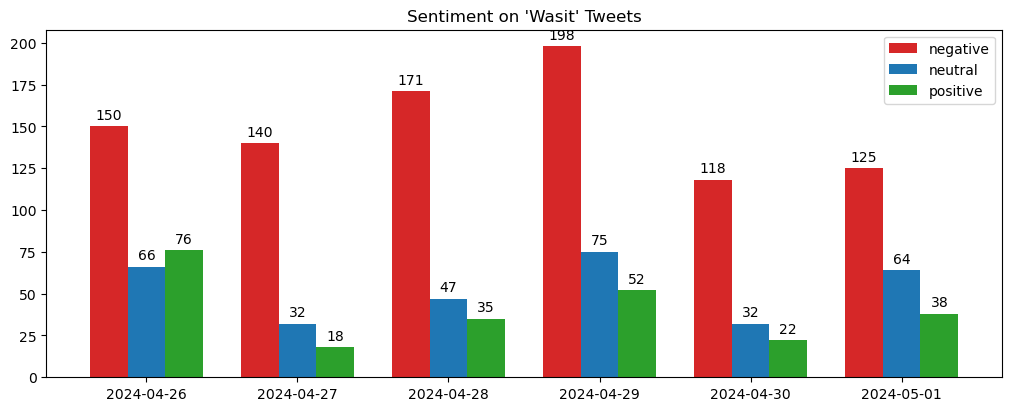

In [16]:
plot_sentiment_chart(wasit_data, "Sentiment on 'Wasit' Tweets")

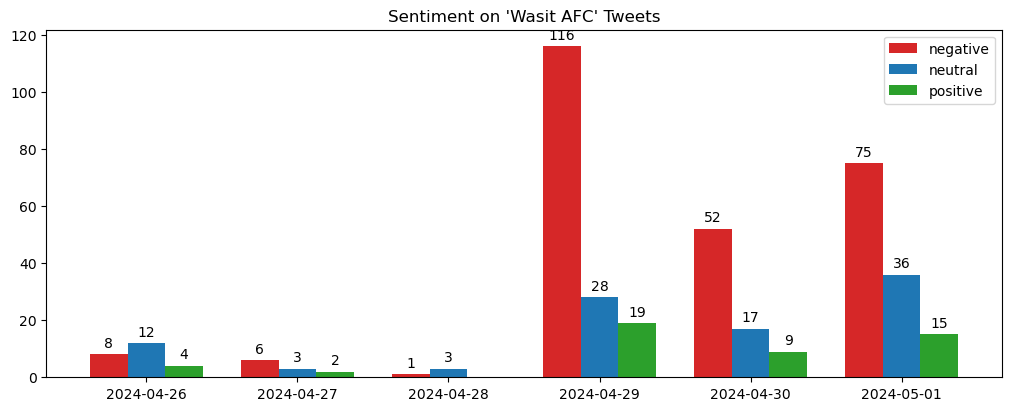

In [17]:
plot_sentiment_chart(wasit_afc_data, "Sentiment on 'Wasit AFC' Tweets")

### Discussion


Dari hasil visualisasi yang melibatkan 1459 _tweets_, terdapat beberapa _insight_ yang bisa didapatkan.

Untuk _chart_ pertama, _Sentiment on "Wasit" Tweets_:

-   Secara umum, _tweet_ dengan kata "wasit" kebanyakan memiliki sentimen negatif
-   Sentimen netral umumnya sedikit lebih banyak dibanding sentimen positif, namun hanya setengah atau bahkan seperempat dibanding sentimen negatif
-   Pada dasarnya tidak ada perubahan tren sentimen yang cukup besar
-   Rentang sentimen: negatif (118 - 198), netral (32 - 75), positif (18 - 76)

Sementara itu, untuk _chart_ kedua, _Sentiment on "Wasit AFC" Tweets_:

-   Sebelum pertandingan semifinal Indonesia pada 29 April, _tweet_ dengan kata "wasit" dan "AFC" sangat sedikit
-   Sebelum pertandingan semifinal itu, _tweet_ terkait wasit AFC tidak terlalu negatif, bahkan lebih banyak yang netral
-   Setelah pertandingan semifinal itu, _tweet_ terkait wasit AFC menjadi sangat banyak dengan didominasi _tweet_ negatif
-   Setelah pertandingan semifinal itu, distribusi sentimen pada _tweet_ terkait wasit AFC menjadi mirip seperti _tweet_ terkait wasit secara umum
-   Pada hari pertandingan semifinal, _tweet_ dengan sentimen negatif bisa lima kali lipat dibanding _tweet_ dengan sentimen netral
-   Menariknya, bahkan setelah pertandingan semifinal, beberapa _tweet_ terkait wasit AFC memiliki sentimen positif, analisis lebih lanjut bisa dilakukan pada _tweet_ seperti ini

Sebelum pembahasan lebih lanjut, perlu _disclaimer_ bahwa analisis ini murni analisis saja.
Tidak ada maksud untuk menganggap baik atau buruk peran wasit ataupun masyarakat Indonesia secara umum.

Secara umum, dapat disimpulkan bahwa masyarakat Indonesia memiliki sentimen negatif terhadap wasit.
Itu mungkin karena jika wasit dianggap merugikan tim favorit masyarakat, maka wasit terkena sentimen negatif.
Namun jika wasit dianggap menguntungkan, maka wasit tidak banyak mendapat pujian karena memang sudah tugasnya.

Karakteristik itu makin jelas pada ajang AFC Cup pada beberapa hari ini.
Ketika wasit dianggap bekerja dengan baik dan Indonesia menang lawan Korea Selatan pada 26 April, tidak banyak sentimen positif terkait wasit AFC.
Namun ketika wasit dianggap merugikan dan Indonesia kalah di semifinal pada 29 April, banyak sentimen negatif yang bermunculan.
Menariknya, ketika kata "wasit" menjadi _trending_ di Twitter setelah pertandingan semifinal itu, _tweet_ terkait wasit AFC yang memiliki sentimen positif juga meningkat.
